In [51]:
import src.get_data as get_data
import src.load_data as load
import src.compute_income as ci

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datetime 

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
from keras import backend as K

import time
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import math
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

WINDOW = 50


In [24]:
df = get_data.get_data_frame().adj_close

In [25]:
def load_data_split_train_test(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

# Normalize function
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [26]:
# Change params and variables
batch_size = 1
nb_epoch = 10
seq_len = 50
input_dim=1
output_dim=50
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'


X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(df.as_matrix(),50, True)

In [27]:
# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print ('compilation time : ', time.time() - start)

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)



/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 1), units=50)`

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(units=1)`



compilation time :  0.01246023178100586
Train on 574 samples, validate on 31 samples
Epoch 1/10
574/574 [==============================] - 24s - loss: 0.0056 - val_loss: 0.0032
Epoch 2/10
574/574 [==============================] - 24s - loss: 0.0034 - val_loss: 0.0029
Epoch 3/10
574/574 [==============================] - 24s - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
574/574 [==============================] - 24s - loss: 0.0023 - val_loss: 0.0035
Epoch 5/10
574/574 [==============================] - 24s - loss: 0.0022 - val_loss: 0.0017
Epoch 6/10
574/574 [==============================] - 24s - loss: 0.0020 - val_loss: 0.0015
Epoch 7/10
574/574 [==============================] - 24s - loss: 0.0018 - val_loss: 0.0011
Epoch 8/10
574/574 [==============================] - 24s - loss: 0.0017 - val_loss: 8.8409e-04
Epoch 9/10
574/574 [==============================] - 24s - loss: 0.0016 - val_loss: 7.3224e-04
Epoch 10/10
574/574 [==============================] - 24s - loss: 0.0016 - val

/root/anaconda/lib/python3.6/site-packages/keras/models.py:826: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Mean squared error (MSE) 0.00547640571497
Root Mean squared error (RMSE) 0.07400274126661098


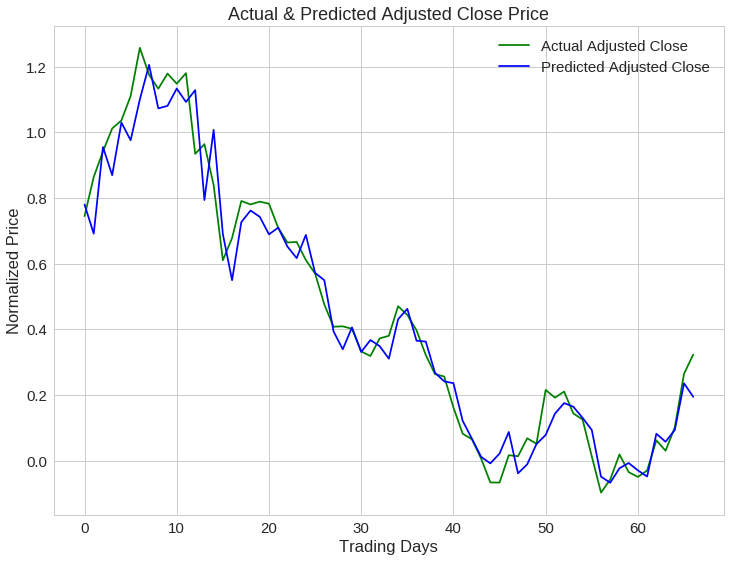

In [28]:
TM_MSE = score
TM_RMSE = math.sqrt(score)
print( 'Mean squared error (MSE)', TM_MSE)
print ('Root Mean squared error (RMSE)', TM_RMSE)

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price')
ax.legend(loc='upper right')

plt.show()

In [43]:
close = go.Scatter( y = get_data.get_data_frame().close.values, name = 'close')
adj_close = go.Scatter( y = get_data.get_data_frame().adj_close.values, name = 'adj_close')

iplot([close,adj_close])
plt.show()
            

In [50]:

def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
    
    return model



In [54]:

def nextDayPrediction(typeBlockchain, stock, N = 1):    
    
    plot = True
    plotHictory = False
    interactiveGrapth = True
    plotForTrain = False
    
    df = get_data.get_data_frame(typeBlockchain, stock)
    df.index = df.date
    df= df[:-1]
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    all_df = df.copy()

    x = all_df[['high', 'low']].copy()
    
    y = all_df['close'].copy()

    x[['high', 'low']] = x_scaler.fit_transform(x)
    
    NUM_FEATURES = x.shape[1]
    
    #y = y_scaler.fit_transform(y.values.reshape(-1, 1))
    x['close'] = y
    
    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.96, TrainTest = True)
    x = x[['high', 'low']]
    
    model = build_model(input_shape=(WINDOW, NUM_FEATURES))
    
    print('START FIT MODEL...')
    
    start = time.time()
    
    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32, epochs=500,verbose=1,
              callbacks=[history])
    
    #model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)
    end = time.time()

    print ('Learning time: ', end-start)
    
    today = time.strftime("_%d_%m_%Y")
    
    pathModel = "../../models/model_5f_ne_" + typeBlockchain + today +".h5"
    save_model(model, pathModel)
    #model = load_model(pathModel)
    # one day prediction. get last batch known data (now we didnt need in y value and can predict it)    
    lastbatch = np.array(x[-WINDOW:])
    pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
    pred =  np.array((pred)) # predicted value ###########################y_scaler.inverse_transform

    # now we make dataframe and create row names in date

    lastDate =str(df.date[df.last_valid_index()]).split('-')
    currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2])) + datetime.timedelta(1)
    predictionDate = pd.date_range(currentData, periods=1)
    prediction = pd.DataFrame(pred, columns=["predictionPrice"], index = predictionDate.values)


    print (prediction)



    if plotForTrain:

        trainPredict = model.predict(X_train)
        trainPredict = y_scaler.inverse_transform(trainPredict)
        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict
        Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
        Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
        ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
        TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

        iplot([ActualValues,TrainingValues])
        plt.show()

    if plot:
        calc_income = all_df.close[-y_test.shape[0]:]
        print (X_train.shape)
        trainPredict = model.predict(X_train)
        testPredict = model.predict(X_test)
        
        #trainPredict = y_scaler.inverse_transform(trainPredict)
        trainY =np.array([y_train])# y_scaler.inverse_transform

        #testPredict = y_scaler.inverse_transform(testPredict)
        m = testPredict
        testY = np.array([y_test])## y_scaler.inverse_transform

        trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
        print('Train Score: %.2f RMSE' % (trainScore))

        testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
        print('Test Score: %.2f RMSE' % (testScore))

    ############################ income ##############################3
        print ('income ACTUAL: ')
        print (ci.calcDOXOD(calc_income, ci.classifyALL(calc_income)    ))
        print ('income PREDICTED: ')
        print (ci.calcDOXOD(calc_income, ci.classifyALL(testPredict.reshape(-1,)))    )   
        
        print (ci.classifyALL(calc_income))
        print (ci.classifyALL(testPredict.reshape(-1,)))
    ############################ number TRUE predicted labels for TREND #######
        print ('% TRUE predicted labels for TREND:')
        quality = np.sum([ci.classifyALL(testY.reshape(-1,)) == ci.classifyALL(testPredict.reshape(-1,))])
        print (quality/testPredict.shape[0])

        prices = df.close.values.astype('float32')
        prices = prices.reshape(len(prices), 1)
        trainPredictPlot = np.empty_like(prices)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

        testPredictPlot = np.empty_like(prices)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[(len(prices) - testPredict.shape[0]):len(prices), :] = testPredict

        plt.plot(pd.DataFrame(prices, columns=["close"], index=df.index).close, label='Actual')
        plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
        plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
        plt.legend(loc='best')
        plt.show()

        interactiveGrapth = 1
        if interactiveGrapth:

            Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
            Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close
            Testing = pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close
            print (testY.reshape(-1,))
            print (m.reshape(-1,))
            ActualValues = go.Scatter( x = df.index, y = Actual, name = 'ActualValues')
            TrainingValues = go.Scatter( x = df.index, y = Training, name = 'TrainingValues')
            TestingValues = go.Scatter( x = df.index, y = Testing, name = 'PredictedValues')

            iplot([ActualValues,TrainingValues, TestingValues])
            plt.show()

        if plotHictory:

            plt.plot(history.history['loss'], label = 'TrainLoss')
            plt.plot(history.history['val_loss'], label = 'TestLoss')
            plt.legend()
            plt.show()
        del model

        K.clear_session()

    return prediction

START FIT MODEL...
Train on 645 samples, validate on 27 samples
Epoch 1/500
645/645 [==============================] - 2s - loss: 1005416.4549 - acc: 0.0000e+00 - val_loss: 6653024.0000 - val_acc: 0.0000e+00
Epoch 2/500
645/645 [==============================] - 1s - loss: 995721.6234 - acc: 0.0000e+00 - val_loss: 6619098.0000 - val_acc: 0.0000e+00
Epoch 3/500
645/645 [==============================] - 1s - loss: 983792.1099 - acc: 0.0000e+00 - val_loss: 6575751.0000 - val_acc: 0.0000e+00
Epoch 4/500
645/645 [==============================] - 1s - loss: 968948.5451 - acc: 0.0000e+00 - val_loss: 6524647.0000 - val_acc: 0.0000e+00
Epoch 5/500
645/645 [==============================] - 1s - loss: 951634.8731 - acc: 0.0000e+00 - val_loss: 6462152.0000 - val_acc: 0.0000e+00
Epoch 6/500
645/645 [==============================] - 1s - loss: 931325.5674 - acc: 0.0000e+00 - val_loss: 6391009.5000 - val_acc: 0.0000e+00
Epoch 7/500
645/645 [==============================] - 1s - loss: 909072.4093

645/645 [==============================] - 1s - loss: 37186.1470 - acc: 0.0031 - val_loss: 501728.9062 - val_acc: 0.0000e+00
Epoch 58/500
645/645 [==============================] - 1s - loss: 31055.6725 - acc: 0.0000e+00 - val_loss: 441227.6875 - val_acc: 0.0000e+00
Epoch 59/500
645/645 [==============================] - 1s - loss: 25414.5641 - acc: 0.0000e+00 - val_loss: 509873.3750 - val_acc: 0.0000e+00
Epoch 60/500
645/645 [==============================] - 1s - loss: 30741.5879 - acc: 0.0000e+00 - val_loss: 312685.5625 - val_acc: 0.0000e+00
Epoch 61/500
645/645 [==============================] - 1s - loss: 21292.9895 - acc: 0.0000e+00 - val_loss: 269781.9062 - val_acc: 0.0000e+00
Epoch 62/500
645/645 [==============================] - 1s - loss: 14494.4069 - acc: 0.0016 - val_loss: 219546.0312 - val_acc: 0.0000e+00
Epoch 63/500
645/645 [==============================] - 1s - loss: 14554.7132 - acc: 0.0000e+00 - val_loss: 187339.9219 - val_acc: 0.0000e+00
Epoch 64/500
645/645 [=====

645/645 [==============================] - 1s - loss: 8538.3543 - acc: 0.0047 - val_loss: 101187.4844 - val_acc: 0.0000e+00
Epoch 116/500
645/645 [==============================] - 1s - loss: 7563.0385 - acc: 0.0016 - val_loss: 97927.8594 - val_acc: 0.0000e+00
Epoch 117/500
645/645 [==============================] - 1s - loss: 6371.9604 - acc: 0.0031 - val_loss: 103386.8203 - val_acc: 0.0000e+00
Epoch 118/500
645/645 [==============================] - 1s - loss: 6977.0331 - acc: 0.0016 - val_loss: 98246.8906 - val_acc: 0.0000e+00
Epoch 119/500
645/645 [==============================] - 1s - loss: 7360.7827 - acc: 0.0031 - val_loss: 95377.7656 - val_acc: 0.0000e+00
Epoch 120/500
645/645 [==============================] - 1s - loss: 6158.9917 - acc: 0.0016 - val_loss: 97344.1797 - val_acc: 0.0000e+00
Epoch 121/500
645/645 [==============================] - 1s - loss: 7370.6554 - acc: 0.0031 - val_loss: 98443.1641 - val_acc: 0.0000e+00
Epoch 122/500
645/645 [==============================

645/645 [==============================] - 1s - loss: 5989.3918 - acc: 0.0000e+00 - val_loss: 92291.3047 - val_acc: 0.0000e+00
Epoch 175/500
645/645 [==============================] - 1s - loss: 5208.3399 - acc: 0.0000e+00 - val_loss: 92046.2734 - val_acc: 0.0000e+00
Epoch 176/500
645/645 [==============================] - 1s - loss: 5472.8026 - acc: 0.0000e+00 - val_loss: 90759.8594 - val_acc: 0.0000e+00
Epoch 177/500
645/645 [==============================] - 1s - loss: 5453.2560 - acc: 0.0016 - val_loss: 84997.4453 - val_acc: 0.0000e+00
Epoch 178/500
645/645 [==============================] - 1s - loss: 5975.2608 - acc: 0.0016 - val_loss: 434207.1562 - val_acc: 0.0000e+00
Epoch 179/500
645/645 [==============================] - 1s - loss: 5872.4466 - acc: 0.0000e+00 - val_loss: 86024.0312 - val_acc: 0.0000e+00
Epoch 180/500
645/645 [==============================] - 1s - loss: 6398.8110 - acc: 0.0047 - val_loss: 93978.3125 - val_acc: 0.0000e+00
Epoch 181/500
645/645 [===============

645/645 [==============================] - 1s - loss: 5092.7015 - acc: 0.0016 - val_loss: 91638.1719 - val_acc: 0.0000e+00
Epoch 234/500
645/645 [==============================] - 1s - loss: 4276.6048 - acc: 0.0016 - val_loss: 91615.7031 - val_acc: 0.0000e+00
Epoch 235/500
645/645 [==============================] - 1s - loss: 5424.4093 - acc: 0.0047 - val_loss: 96079.7578 - val_acc: 0.0000e+00
Epoch 236/500
645/645 [==============================] - 1s - loss: 5250.4367 - acc: 0.0000e+00 - val_loss: 92412.0078 - val_acc: 0.0000e+00
Epoch 237/500
645/645 [==============================] - 1s - loss: 4661.5665 - acc: 0.0016 - val_loss: 90789.0469 - val_acc: 0.0000e+00
Epoch 238/500
645/645 [==============================] - 1s - loss: 5081.2330 - acc: 0.0031 - val_loss: 99148.7812 - val_acc: 0.0000e+00
Epoch 239/500
645/645 [==============================] - 1s - loss: 4486.6772 - acc: 0.0016 - val_loss: 97994.7344 - val_acc: 0.0000e+00
Epoch 240/500
645/645 [============================

645/645 [==============================] - 1s - loss: 4022.7080 - acc: 0.0031 - val_loss: 97512.3672 - val_acc: 0.0000e+00
Epoch 293/500
645/645 [==============================] - 1s - loss: 4652.1666 - acc: 0.0016 - val_loss: 102879.5547 - val_acc: 0.0000e+00
Epoch 294/500
645/645 [==============================] - 1s - loss: 5076.6505 - acc: 0.0031 - val_loss: 94614.0938 - val_acc: 0.0000e+00
Epoch 295/500
645/645 [==============================] - 1s - loss: 4864.4253 - acc: 0.0031 - val_loss: 89196.2188 - val_acc: 0.0000e+00
Epoch 296/500
645/645 [==============================] - 1s - loss: 4030.0733 - acc: 0.0016 - val_loss: 95486.0234 - val_acc: 0.0000e+00
Epoch 297/500
645/645 [==============================] - 1s - loss: 4670.4037 - acc: 0.0031 - val_loss: 90382.4531 - val_acc: 0.0000e+00
Epoch 298/500
645/645 [==============================] - 1s - loss: 4424.3717 - acc: 0.0000e+00 - val_loss: 97713.8828 - val_acc: 0.0000e+00
Epoch 299/500
645/645 [===========================

645/645 [==============================] - 1s - loss: 4375.7527 - acc: 0.0000e+00 - val_loss: 86828.4844 - val_acc: 0.0000e+00
Epoch 352/500
645/645 [==============================] - 1s - loss: 4387.0412 - acc: 0.0000e+00 - val_loss: 93471.8516 - val_acc: 0.0000e+00
Epoch 353/500
645/645 [==============================] - 1s - loss: 3925.3564 - acc: 0.0016 - val_loss: 92337.7031 - val_acc: 0.0000e+00
Epoch 354/500
645/645 [==============================] - 1s - loss: 3798.3395 - acc: 0.0047 - val_loss: 91075.0469 - val_acc: 0.0000e+00
Epoch 355/500
645/645 [==============================] - 1s - loss: 4711.2832 - acc: 0.0016 - val_loss: 96374.8281 - val_acc: 0.0000e+00
Epoch 356/500
645/645 [==============================] - 1s - loss: 4811.3151 - acc: 0.0031 - val_loss: 86556.1328 - val_acc: 0.0000e+00
Epoch 357/500
645/645 [==============================] - 1s - loss: 3594.2832 - acc: 0.0016 - val_loss: 86521.1875 - val_acc: 0.0000e+00
Epoch 358/500
645/645 [========================

645/645 [==============================] - 1s - loss: 3872.6201 - acc: 0.0047 - val_loss: 84411.9609 - val_acc: 0.0000e+00
Epoch 411/500
645/645 [==============================] - 1s - loss: 4777.8186 - acc: 0.0016 - val_loss: 89743.3750 - val_acc: 0.0000e+00
Epoch 412/500
645/645 [==============================] - 1s - loss: 4102.2132 - acc: 0.0062 - val_loss: 91950.5156 - val_acc: 0.0000e+00
Epoch 413/500
645/645 [==============================] - 1s - loss: 3650.5742 - acc: 0.0031 - val_loss: 92954.8672 - val_acc: 0.0000e+00
Epoch 414/500
645/645 [==============================] - 1s - loss: 4183.7335 - acc: 0.0016 - val_loss: 89910.3906 - val_acc: 0.0000e+00
Epoch 415/500
645/645 [==============================] - 1s - loss: 3669.7948 - acc: 0.0016 - val_loss: 85836.4062 - val_acc: 0.0000e+00
Epoch 416/500
645/645 [==============================] - 1s - loss: 4914.4544 - acc: 0.0016 - val_loss: 89087.5234 - val_acc: 0.0000e+00
Epoch 417/500
645/645 [==============================] 

645/645 [==============================] - 1s - loss: 3722.5454 - acc: 0.0031 - val_loss: 96198.7188 - val_acc: 0.0000e+00
Epoch 470/500
645/645 [==============================] - 1s - loss: 3576.1862 - acc: 0.0016 - val_loss: 105044.6094 - val_acc: 0.0000e+00
Epoch 471/500
645/645 [==============================] - 1s - loss: 4015.9589 - acc: 0.0031 - val_loss: 92753.4531 - val_acc: 0.0000e+00
Epoch 472/500
645/645 [==============================] - 1s - loss: 3367.0770 - acc: 0.0062 - val_loss: 78743.1094 - val_acc: 0.0000e+00
Epoch 473/500
645/645 [==============================] - 1s - loss: 3412.7016 - acc: 0.0047 - val_loss: 119846.4453 - val_acc: 0.0000e+00
Epoch 474/500
645/645 [==============================] - 1s - loss: 3663.7262 - acc: 0.0016 - val_loss: 94540.4531 - val_acc: 0.0000e+00
Epoch 475/500
645/645 [==============================] - 1s - loss: 3538.2426 - acc: 0.0047 - val_loss: 95151.3281 - val_acc: 0.0000e+00
Epoch 476/500
645/645 [==============================

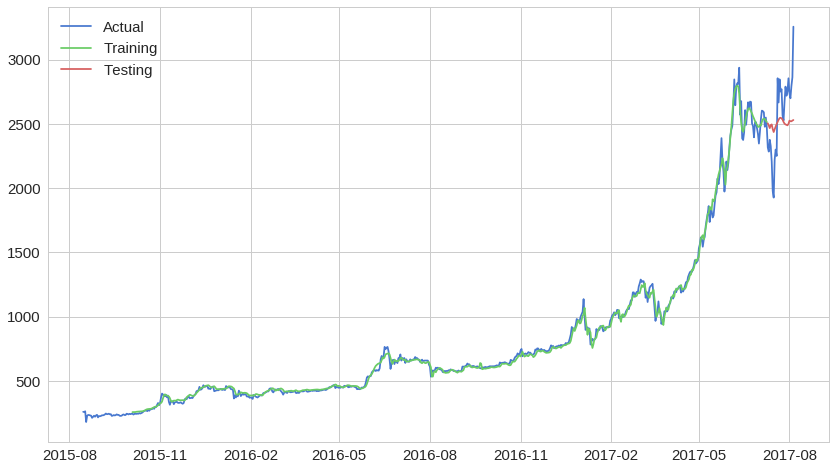

[ 2316.          2283.99552336  2375.92499996  2327.26714203  2205.90730017
  1977.5         1925.89999989  2223.40308238  2299.99999958  2249.99999972
  2855.          2666.69902964  2847.          2751.43083445  2769.36363636
  2565.99999948  2526.35064673  2669.999998    2789.98120002  2719.00000003
  2753.          2855.          2736.48268487  2699.          2794.88999995
  2863.0099985   3256.53665595]
[ 2504.24975586  2487.08544922  2466.82836914  2490.22045898  2495.74023438
  2459.8581543   2436.29882812  2457.80639648  2479.28173828  2498.1940918
  2514.56152344  2532.29345703  2544.89428711  2547.80151367  2542.6315918
  2533.30419922  2515.3503418   2501.85839844  2495.69702148  2492.66772461
  2488.78442383  2499.765625    2525.21972656  2520.17236328  2519.98950195
  2525.73071289  2529.95947266]


In [55]:
USDT_BTC = nextDayPrediction('USDT_BTC', 'poloniex' )

In [ ]:
USDT_LTC = nextDayPrediction('USDT_LTC', 'poloniex')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Learning time:  2.384185791015625e-07
            predictionPrice
2017-08-05       281.958618
Train Score: 1.88 RMSE
Test Score: 50.01 RMSE
income ACTUAL: 
197.75570344
income PREDICTED: 
76.88410034
% TRUE predicted labels for TREND:
0.642857142857


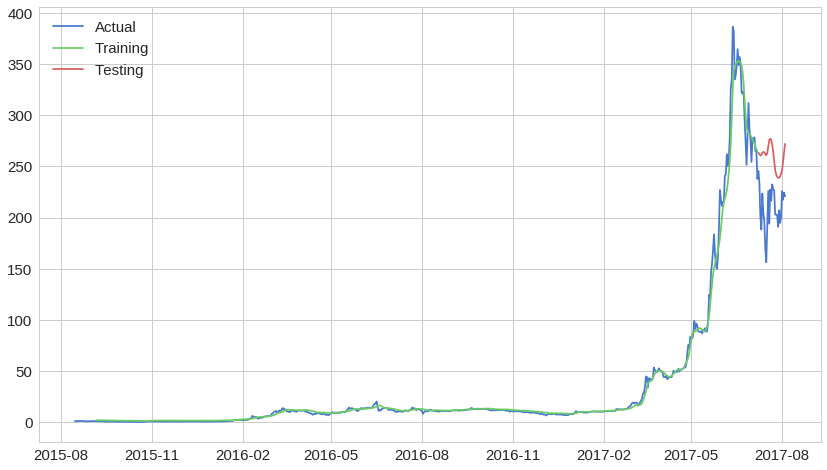

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:157: FutureWarning:

to_datetime is deprecated. Use pd.to_datetime(...)



In [18]:
USDT_ETH = nextDayPrediction('USDT_ETH', 'poloniex')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Learning time:  2.384185791015625e-07
            predictionPrice
2017-08-05        17.300598
Train Score: 0.15 RMSE
Test Score: 3.19 RMSE
income ACTUAL: 
1.35062425
income PREDICTED: 
-3.1213516
% TRUE predicted labels for TREND:
0.214285714286


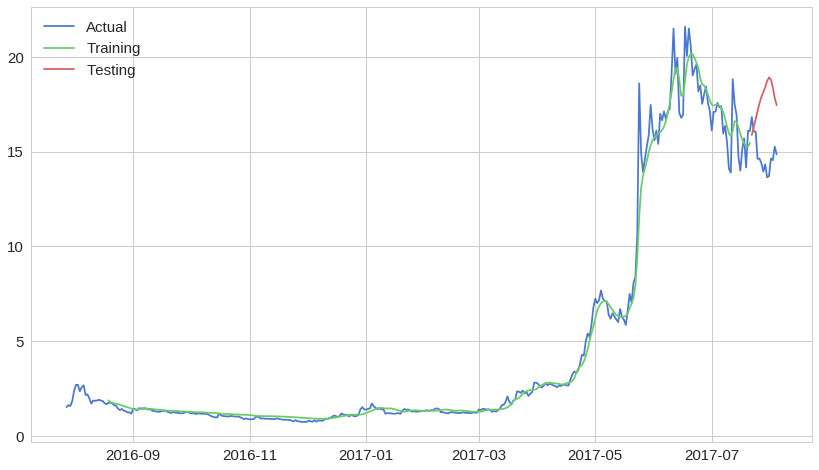

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:157: FutureWarning:

to_datetime is deprecated. Use pd.to_datetime(...)



In [19]:
USDT_ETC = nextDayPrediction('USDT_ETC', 'poloniex')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Learning time:  7.152557373046875e-07
            predictionPrice
2017-08-05         0.249983
Train Score: 0.00 RMSE
Test Score: 0.07 RMSE
income ACTUAL: 
0.11591715
income PREDICTED: 
-0.02140056
% TRUE predicted labels for TREND:
0.75


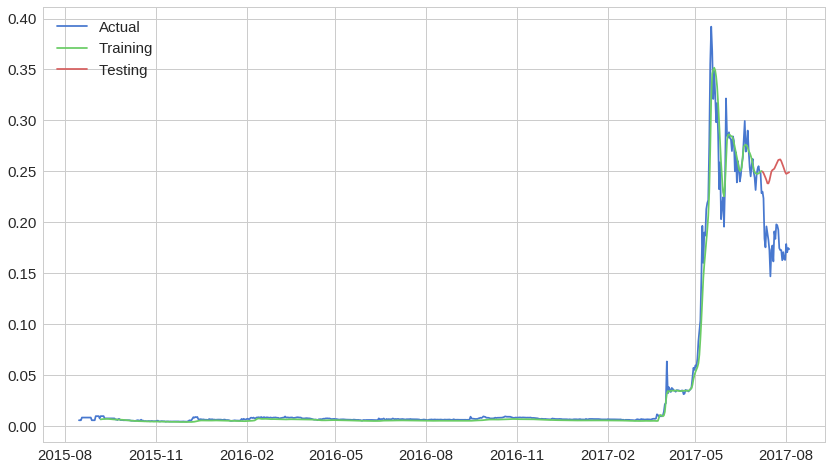

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:157: FutureWarning:

to_datetime is deprecated. Use pd.to_datetime(...)



In [20]:
USDT_XRP = nextDayPrediction('USDT_XRP', 'poloniex',N = 1)